## Importing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output


from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# <span>View dataset</span>

In [3]:
train = pd.read_csv("./dataset/train_data.csv")
test = pd.read_csv("./dataset/test_data.csv")

In [4]:
train.count()

name                 4000
brand                4000
categories           4000
primaryCategories    4000
reviews.date         4000
reviews.text         4000
reviews.title        3990
sentiment            4000
dtype: int64

<p>We are able to observe that there are 4000 entries in the train dataset, for each column except <strong style="color: red;">reviews.title</strong>. This indicates that there are 10 missing or null entries, which should be treated in the later sections.</p>


In [5]:
test.count()

name                 1000
brand                1000
categories           1000
primaryCategories    1000
reviews.date         1000
reviews.text         1000
reviews.title         997
dtype: int64

We are able to observe that there are 1000 entries in the test dataset, for each column except <strong style="color: red;">reviews.title</strong>. This indicates that there are 3 missing or null entries, which should be treated in the later sections.

In [6]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [7]:
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet
freq,169,1000,169,676,26,2,22


In [8]:
train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [9]:
test.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


# <span>1.1 Cleaning and preparing dataset</span>

### <strong style="color: blue;">1.1a Clean the data of errors and inconsistencies</strong>

#### <span >1.1a (i) Dealing with duplicates</span>

In [10]:
# Viewing train duplicates
print("Number of duplicates in train dataset: " + str(train.duplicated().sum()))

Number of duplicates in train dataset: 58


In [11]:
# Viewing test duplicates
print("Number of duplicates in test dataset: " + str(test.duplicated().sum()))

Number of duplicates in test dataset: 3


In [12]:
# Dropping train & test duplicates
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [13]:
# View the train dataset after dropping (dropped 58 entries)
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3942,3942,3942,3942,3942,3942,3932,3942
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,3942,628,2562,98,4,99,3694


In [14]:
# View the test dataset after dropping (dropped 3 entries)
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,997,997,997,997,997,997,994
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,Got this tablet for my 7yr old daughter and it...,Great tablet
freq,169,997,169,673,26,2,22


### <strong style="color: blue;">1.1b Deal with missing values and outliers</strong>

#### <span >1.1b (i) Dealing with missing or null values</span>

In [15]:
train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [16]:
test.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

In [17]:
train.dropna(axis=0, inplace = True)
test.dropna(axis=0, inplace= True)

In [18]:
train.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        0
sentiment            0
dtype: int64

In [19]:
test.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        0
dtype: int64

In [20]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3932,3932,3932,3932,3932,3932,3932,3932
unique,23,1,23,4,630,3590,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,667,3932,628,2561,98,4,99,3684


In [21]:
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,994,994,994,994,994,994,994
unique,23,1,23,4,363,976,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,A great new Amazon device to add to my other A...,Great tablet
freq,169,994,169,673,26,2,22


#### <span >1.1b (ii) Dealing with outliers</span>

In [22]:
train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [23]:
test.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
dtype: object

<p>The IQR method looks at the middle 50% of the data. Anything outside of 1.5 * IQR from the 1st and 3rd quartiles is considered an outlier. However since there all the types of the columns are of object type not numerical we don't deal with outliers.</p>

### <strong style="color: blue;">1.1c Transform the data into a format suitable for analysis and processing</strong>

#### <span >1.1c (i) Imputations</span>

In [24]:
train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

<p>No Imputations needed since there are no numerical entries </p>

#### <span >1.1c (ii) Adding/removing columns</span>

In [25]:
# Ensure 'reviews.date' is in datetime format
train['reviews.date'] = pd.to_datetime(train['reviews.date'])

# Create a new column 'review_year' by extracting the year from 'reviews.date'
train['review_year'] = train['reviews.date'].dt.year


In [26]:
train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_year
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,2016
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17 00:00:00+00:00,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,2018
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral,2017
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04 00:00:00+00:00,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,2017
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,2017


#### <span >1.1c (iii) Renaming columns</span>

In [27]:
train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment', 'review_year'],
      dtype='object')

In [28]:
train.rename(columns = {'reviews.text':'reviews_text', 'reviews.title':'reviews_title','reviews.date':'reviews_date', 'name':'product_name','brand':'product_brand','categories':'product_category','primaryCategories':'product_primary_category'}, inplace = True)

In [29]:
train.columns

Index(['product_name', 'product_brand', 'product_category',
       'product_primary_category', 'reviews_date', 'reviews_text',
       'reviews_title', 'sentiment', 'review_year'],
      dtype='object')

# <span>1.2 Conducting exploratory data analysis (EDA)</span>

### <strong style="color: blue;">1.2a Explore the data to understand its distribution, the relationships between variables, and note any outlier</strong>

In [30]:
train.dtypes

product_name                             object
product_brand                            object
product_category                         object
product_primary_category                 object
reviews_date                datetime64[ns, UTC]
reviews_text                             object
reviews_title                            object
sentiment                                object
review_year                               int32
dtype: object

<p>We can observe that there are only object types and no numerical values thus outliers are out of scope.</p>

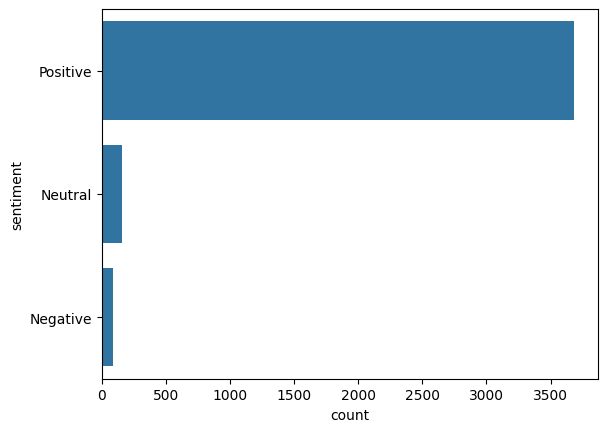

In [31]:
sns.countplot(y=train.sentiment);

<Axes: ylabel='count'>

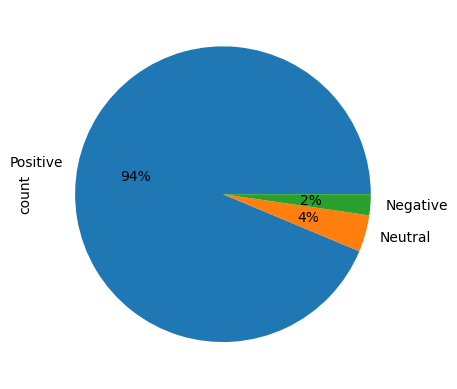

In [32]:
train['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')

In [33]:
train.sentiment.value_counts()

sentiment
Positive    3684
Neutral      158
Negative      90
Name: count, dtype: int64

<p>Based on the bar chart above it shows that there is an overwhelming entries with positive sentiment. Thus this indicates a <strong>class imbalance</strong> problem.</p>

In [34]:
# train = train[train.sentiment != "Neutral"]

<p>We are using the Neutral sentiment as it gives actionable insights for companies later on, thus we are not dropping any sentiments.</p>

Positive words


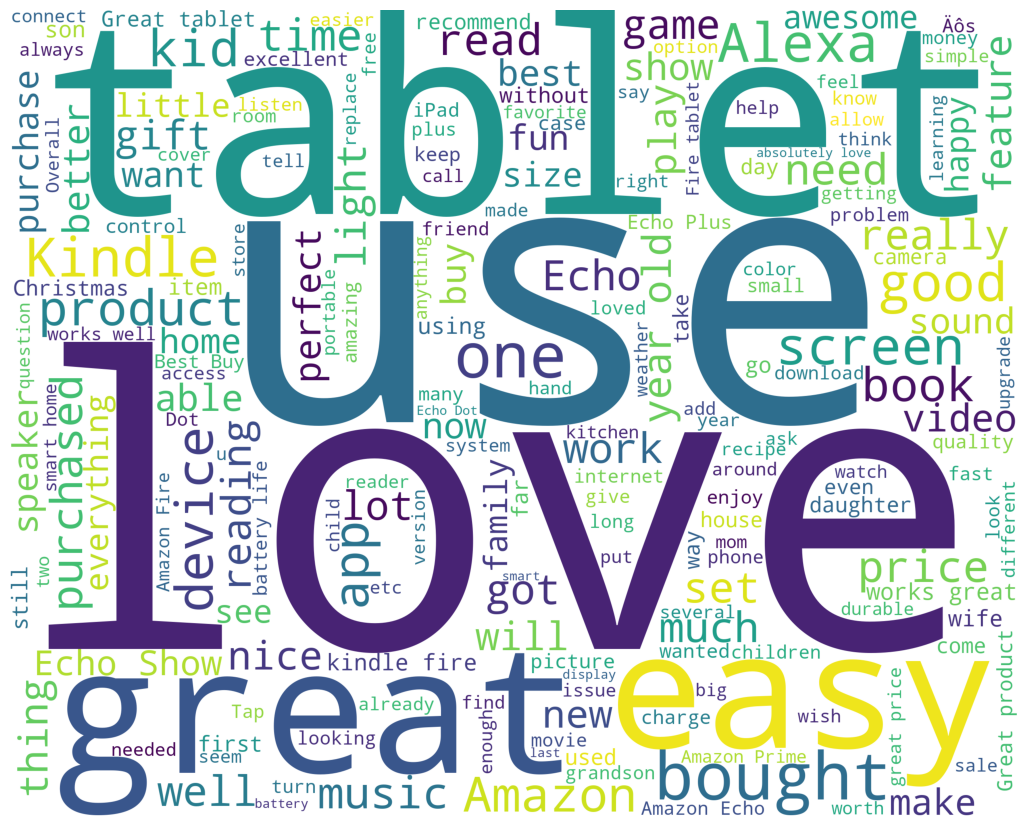

Negative words


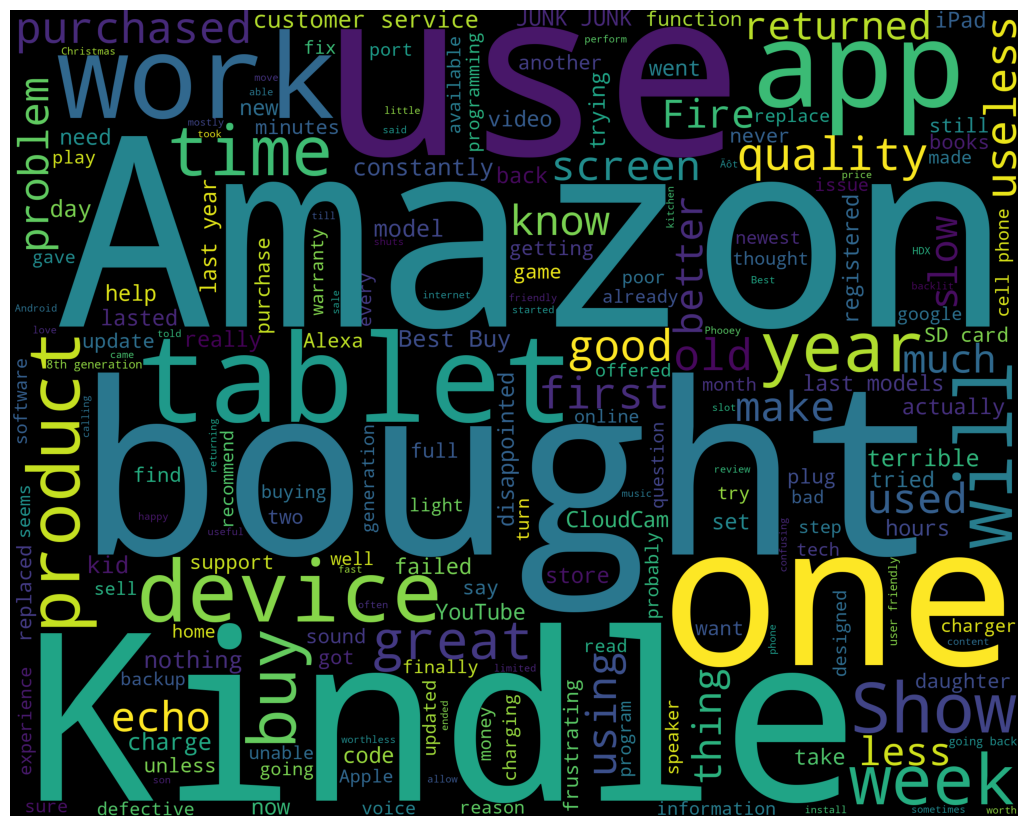

Neutral words


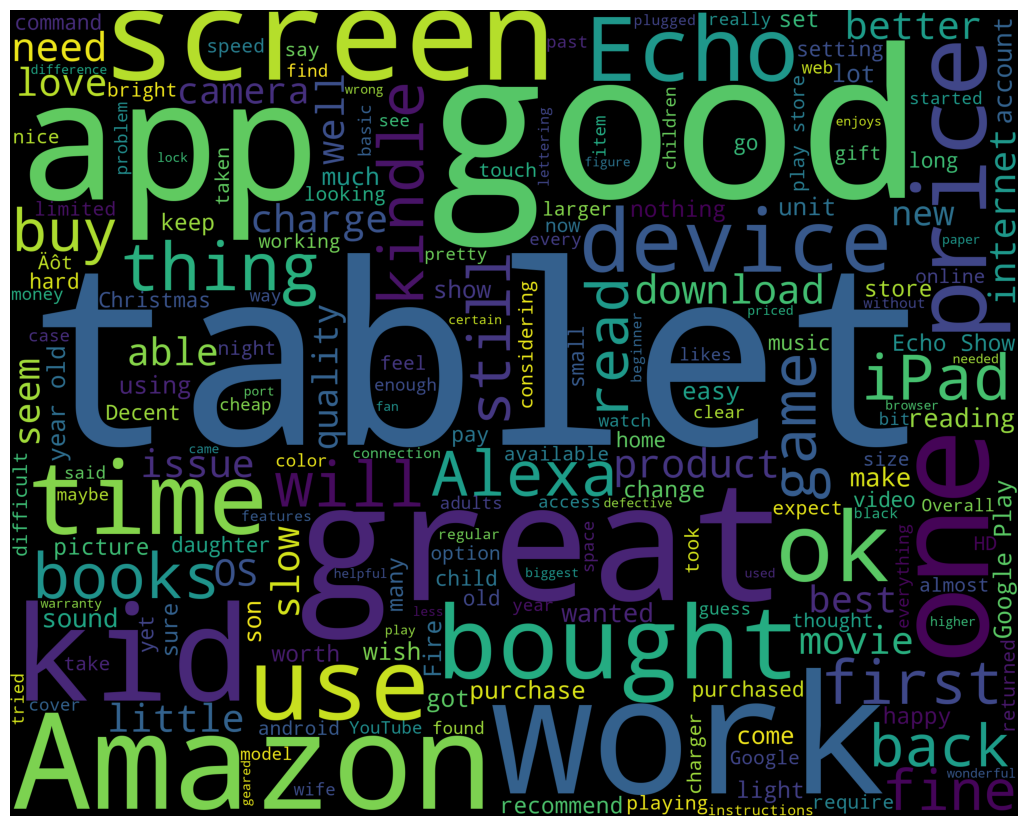

In [39]:
from wordcloud import WordCloud,STOPWORDS

train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['reviews_text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['reviews_text']
train_neu = train[ train['sentiment'] == 'Neutral']
train_neu = train_neu['reviews_text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)
print("Neutral words")
wordcloud_draw(train_neu)

<p>We have visualized the positive, negative & neutral words in the train dataset.</p>

# <span>1.3 Further data preprocessing after EDA</span>

### <strong style="color: blue;">1.3a Removing stopwords</strong>
<span>tldr: Stop words are the words in a stop list which are filtered out before or after processing of natural language data because they are deemed insignificant</span>

In [40]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words